In [ ]:
%%capture --no-stderr
!pip install langchain langchain_openai langgraph chromadb langchain_community  --q
!apt install libgraphviz-dev
!pip install pygraphviz --q

### Get the credentials

In [ ]:
from google.colab import userdata
import os
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY')

### Set up LLM

In [ ]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)

### Create tools
 - Multiply
 - Search

In [ ]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

@tool
def multiply(first_number: int, second_number: int)->int:
    """Multiplies two interger together."""
    return first_number * second_number

@tool
def search(query: str):
    """perform web search on the user query"""
    tavily = TavilySearchResults(max_results=1)
    result = tavily.invoke(query)
    return result

### Combine the tools and Bind to the LLM

In [ ]:
tools = [search,multiply]

In [ ]:
tool_map = {tool.name: tool for tool in tools}

In [ ]:
tool_map

{'search': StructuredTool(name='search', description='perform web search on the user query', args_schema=<class 'pydantic.v1.main.searchSchema'>, func=<function search at 0x7c43202d1120>),
 'multiply': StructuredTool(name='multiply', description='Multiplies two interger together.', args_schema=<class 'pydantic.v1.main.multiplySchema'>, func=<function multiply at 0x7c4320304040>)}

In [ ]:
model_with_tools = model.bind_tools(tools)

### Checking the tool calling with Specific questions

In [ ]:
res = model_with_tools.invoke('Search from internet and tell me who won the T20 Cricket world cup in 2024?')
for i in res.additional_kwargs.get("tool_calls", []):
    print(i)

{'id': 'call_8FGBk77R4zEvmqYtfUVXKRJB', 'function': {'arguments': '{"query":"T20 Cricket World Cup winner 2024"}', 'name': 'search'}, 'type': 'function'}


In [ ]:
tool_map[i['function']['name']].invoke(i['function']['arguments'])

[{'url': 'https://www.espncricinfo.com/story/t20-world-cup-2024-final-ind-vs-sa-all-you-need-to-know-about-the-final-1441307',
  'content': 'While India won the first ever T20 World Cup, in 2007, they are without a World Cup title since 2011 and their last ICC silverware was the 2013 Champions Trophy.They have come close since ...'}]

In [ ]:
res = model_with_tools.invoke('What is 24*365')
for i in res.additional_kwargs.get("tool_calls", []):
    print(i)

{'id': 'call_11EhEzTvY4YQP6FVvalazDNh', 'function': {'arguments': '{"first_number":24,"second_number":365}', 'name': 'multiply'}, 'type': 'function'}


### Graph creation

In [ ]:
from typing import TypedDict, Annotated, Sequence
import operator,json
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [ ]:
def invoke_model(state):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

### Bring human in the loop

-- Bring human approval for costly tool calls or where we need validation

In [ ]:
def invoke_tool(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    tool_details = None

    for tool_call in tool_calls:
        tool_details = tool_call

    if tool_details is None:
        raise Exception("No adder input found.")

    print(f'Selected tool: {tool_details.get("function").get("name")}')

    if tool_details.get("function").get("name") == "search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise ValueError

    response = tool_map[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}

In [ ]:
from langgraph.graph import StateGraph,END

graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("agent", invoke_model)

graph.add_node("tool", invoke_tool)

def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

graph.add_conditional_edges("agent", router, {
    "tool": "tool",
    "end": END,
})

graph.add_edge("tool", END)

graph.set_entry_point("agent")

In [ ]:
app = graph.compile()

In [ ]:
from IPython.display import Image, display

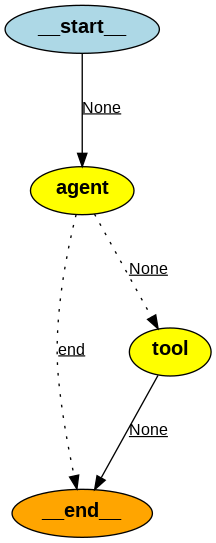

In [ ]:
display(Image(app.get_graph().draw_png()))

### Testing with Questions

In [ ]:
for s in app.stream({"messages": ["What is 24 * 365?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r4Rq0SM8sDtGLx27RsRMTMnr', 'function': {'arguments': '{"first_number":24,"second_number":365}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 80, 'total_tokens': 99}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-84a7d636-006a-4efc-9736-2fdf63414f0d-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 24, 'second_number': 365}, 'id': 'call_r4Rq0SM8sDtGLx27RsRMTMnr'}], usage_metadata={'input_tokens': 80, 'output_tokens': 19, 'total_tokens': 99})]}
----
Selected tool: multiply
{'messages': [8760]}
----


In [ ]:
for s in app.stream({"messages": ["Who won the T20 Cricket world cup in 2024?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AohcA1zh2ry3XZO8NSr85kJI', 'function': {'arguments': '{"query":"T20 Cricket World Cup winner 2024"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 85, 'total_tokens': 106}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-028725ee-97e8-44f9-ac3e-e50387471806-0', tool_calls=[{'name': 'search', 'args': {'query': 'T20 Cricket World Cup winner 2024'}, 'id': 'call_AohcA1zh2ry3XZO8NSr85kJI'}], usage_metadata={'input_tokens': 85, 'output_tokens': 21, 'total_tokens': 106})]}
----
Selected tool: search
[y/n] continue with expensive web search?y
{'messages': [[{'url': 'https://www.cnn.com/2024/06/29/sport/india-south-africa-t20-mens-world-cup-final-spt-intl/index.html', 'content': "India produced a brilliant performance to defeat South Africa in a dramatic men's T20 Wor

In [ ]:
for s in app.stream({"messages": ["Who won the T20 Cricket world cup in 2022?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Yecz9BpJ6y1S7PLUpvuvkeqT', 'function': {'arguments': '{"query":"T20 Cricket World Cup 2022 winner"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 85, 'total_tokens': 106}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-79a65eb5-c2d1-4f39-baf8-cdbd3c42311f-0', tool_calls=[{'name': 'search', 'args': {'query': 'T20 Cricket World Cup 2022 winner'}, 'id': 'call_Yecz9BpJ6y1S7PLUpvuvkeqT'}], usage_metadata={'input_tokens': 85, 'output_tokens': 21, 'total_tokens': 106})]}
----
Selected tool: search
[y/n] continue with expensive web search?n


ValueError: 